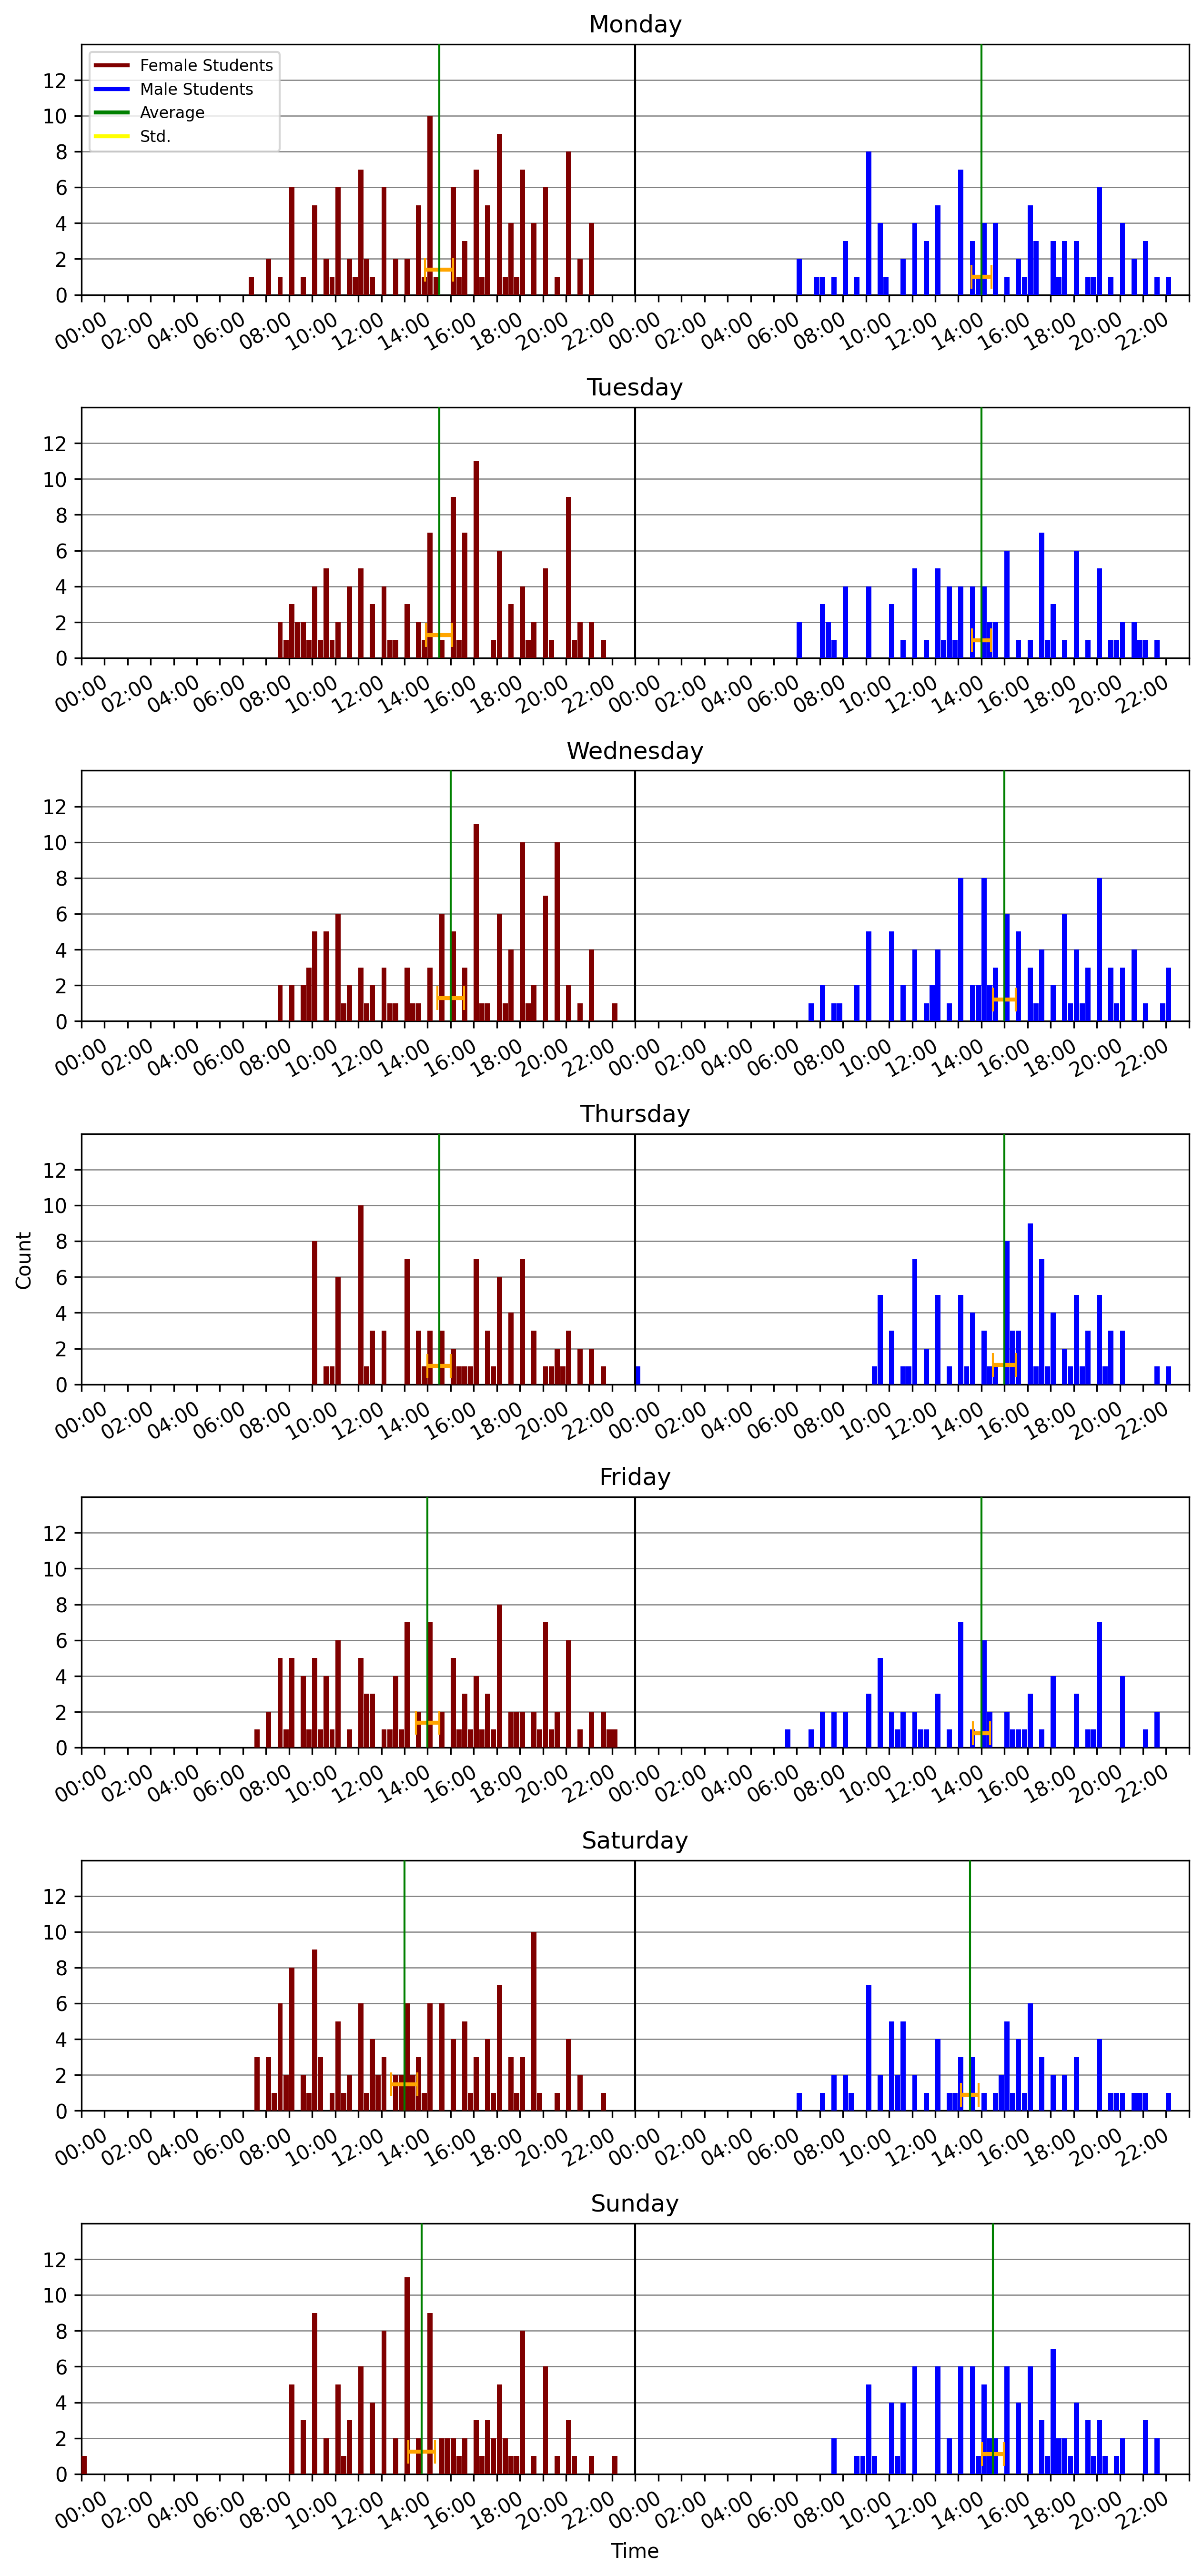

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kruskal 
from matplotlib.lines import Line2D


data = pd.read_csv('anonymized.csv')
# date_format = "%a,%d,%b,%Y,%H:%M"
df = data
df.insert(2, 'date', '')
df['date'] = pd.to_datetime(df['day'].astype(str) + ' ' + df['month'] + ' ' + df['year'].astype(str), format='%d %B %Y')
df = df.drop_duplicates(subset=['pseudonym', 'date', 'start_time'])

# Drop the original 'day', 'month', and 'year' columns if needed
df = df.drop(columns=['day', 'month', 'year'])

weekdays = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']
weekdays_dict = {
    'Mo': "Monday",
    'Di': "Tuesday",
    'Mi': "Wednesday",
    'Do': "Thursday",
    'Fr': "Friday",
    'Sa': "Saturday",
    'So': "Sunday"
}

weekdays_data_dict_female = {
    'Mo': "time_sum_monday_w",
    'Di': "time_sum_tuesday_w",
    'Mi': "time_sum_wednesday_w",
    'Do': "time_sum_thursday_w",
    'Fr': "time_sum_friday_w",
    'Sa': "time_sum_saturday_w",
    'So': "time_sum_sunday_w"
}

weekdays_data_dict_male = {
    'Mo': "time_sum_monday_m",
    'Di': "time_sum_tuesday_m",
    'Mi': "time_sum_wednesday_m",
    'Do': "time_sum_thursday_m",
    'Fr': "time_sum_friday_m",
    'Sa': "time_sum_saturday_m",
    'So': "time_sum_sunday_m"
}

# Removes the cleaning lady from the data
men_data = df.loc[df['sex'] == 'm']
women_data_with_putzfrau = df.loc[df['sex'] == 'f']
women_data = women_data_with_putzfrau.loc[women_data_with_putzfrau['pseudonym'] != 'Putzfrau']

all_data_men = np.zeros(96, dtype=int)
all_data_women = np.zeros(96, dtype=int)

# Sum of all washing machine usages per day and in general
for index_day, day in enumerate(weekdays):
    woman_data_weekday = women_data.loc[women_data['weekday'] == day]
    male_data_weekday = men_data.loc[men_data['weekday'] == day]

    weekdays_data_dict_female[day] = np.zeros(96, dtype=int)
    weekdays_data_dict_male[day] = np.zeros(96, dtype=int)
    
    for time_i in woman_data_weekday['start_time']:
        ind = int(int(time_i.split(':')[0]) * 4 + (int(time_i.split(':')[1]) / 15))
        weekdays_data_dict_female[day][ind] += 1
        
    for time_i in male_data_weekday['start_time']:
        ind = int(int(time_i.split(':')[0]) * 4 + (int(time_i.split(':')[1]) / 15))
        weekdays_data_dict_male[day][ind] += 1
        
    all_data_men = all_data_men + weekdays_data_dict_male[day]
    all_data_women = all_data_women + weekdays_data_dict_female[day]
        
        
intervals = list(range(192))
fig, ax = plt.subplots(nrows=7, figsize=(10, 25), sharex=False, dpi=300, zorder=4)
zeroes_array = np.zeros(96, dtype=int)

time_stamps = np.linspace(0, 192, 49)
time_labels = ["00:00", "", "02:00", "", "04:00", "", "06:00", "", "08:00", "", "10:00", "", "12:00", "", "14:00", "", "16:00", "", "18:00", "", "20:00", "", "22:00", "", "00:00", "", "02:00", "", "04:00", "", "06:00", "", "08:00", "", "10:00", "", "12:00", "", "14:00", "", "16:00", "", "18:00", "", "20:00", "", "22:00", "", ""]

ax[6].set_xlabel("Time") 
ax[3].set_ylabel("Count")
plt.subplots_adjust(hspace=0.45, bottom=0.2)

y_pos = [2, 4, 6, 8, 10, 12, 14]

# Set x- and y-axis
for subplot in ax:
    subplot.set_xlim(0, 192)
    subplot.set_ylim(0, 14)
    subplot.set_xticks(time_stamps)
    subplot.set_xticklabels(labels=time_labels, rotation=30)
    subplot.set_yticks(np.arange(0, 13, step=2))
    for yc in y_pos:
        subplot.axhline(y=yc, color='grey', linewidth=0.6, zorder=2)
    subplot.axvline(x=96, color='black', linewidth=1, zorder=4)

# Creates the plots for all weekdays
for index, day in enumerate(weekdays_data_dict_female):
    
    ax[index].bar(intervals, np.concatenate((zeroes_array, weekdays_data_dict_male[day]), axis=0), label='Set1', width=0.9, color='blue', align='edge', zorder=3)
    ax[index].bar(intervals, np.concatenate((weekdays_data_dict_female[day], zeroes_array), axis=0), label='Set1', width=0.9, color='maroon', align='edge', zorder=3)
    
    ax[index].errorbar(x=np.round(np.average(np.arange(96), weights=weekdays_data_dict_male[day]))+96, y=np.average(weekdays_data_dict_male[day]), xerr=np.std(weekdays_data_dict_male[day]), linewidth=2, capsize=6, zorder=4, color='green', ecolor='orange')
    ax[index].errorbar(x=np.round(np.average(np.arange(96), weights=weekdays_data_dict_female[day])), y=np.average(weekdays_data_dict_female[day]), xerr=np.std(weekdays_data_dict_female[day]), linewidth=2, capsize=6, zorder=4, color='green', ecolor='orange')
    
    ax[index].axvline(x=np.round(np.average(np.arange(96), weights=weekdays_data_dict_male[day]))+96, color='green', linewidth=1, zorder=4)
    ax[index].axvline(x=np.round(np.average(np.arange(96), weights=weekdays_data_dict_female[day])), color='green', linewidth=1, zorder=4)
    
    max_times_woman = np.flatnonzero(weekdays_data_dict_female[day] == np.max(weekdays_data_dict_female[day])).tolist()
    for index_times, times in enumerate(max_times_woman):
        max_times_woman[index_times] = f"{3*times // 12:02d}:{(3*times % 12) * 5:02d}"
        
    if len(max_times_woman) == 1:
        plural_w = "Time"
    else:
        plural_w = "Times"
        
    max_times_man = np.flatnonzero(weekdays_data_dict_male[day] == np.max(weekdays_data_dict_male[day])).tolist()
    for index_times, times in enumerate(max_times_man):
        max_times_man[index_times] = f"{3*times // 12:02d}:{(3*times % 12) * 5:02d}"
        
    if len(max_times_man) == 1:
        plural_m = "Time"
    else:
        plural_m = "Times"
        
    custom_lines = [Line2D([0], [0], color='maroon', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='yellow', lw=2)]
    ax[0].legend(custom_lines, ['Female Students', 'Male Students', 'Average', 'Std.'], prop={'size': 8}, loc='upper left')
    ax[index].set_title(f"{weekdays_dict[day]}")
    
plt.show()

In [67]:
# Kruskall H-Test
data_men = all_data_men.tolist()
data_women = all_data_women.tolist()
kruskal(all_data_men, all_data_women)

KruskalResult(statistic=0.24771739616432134, pvalue=0.6186869346808139)

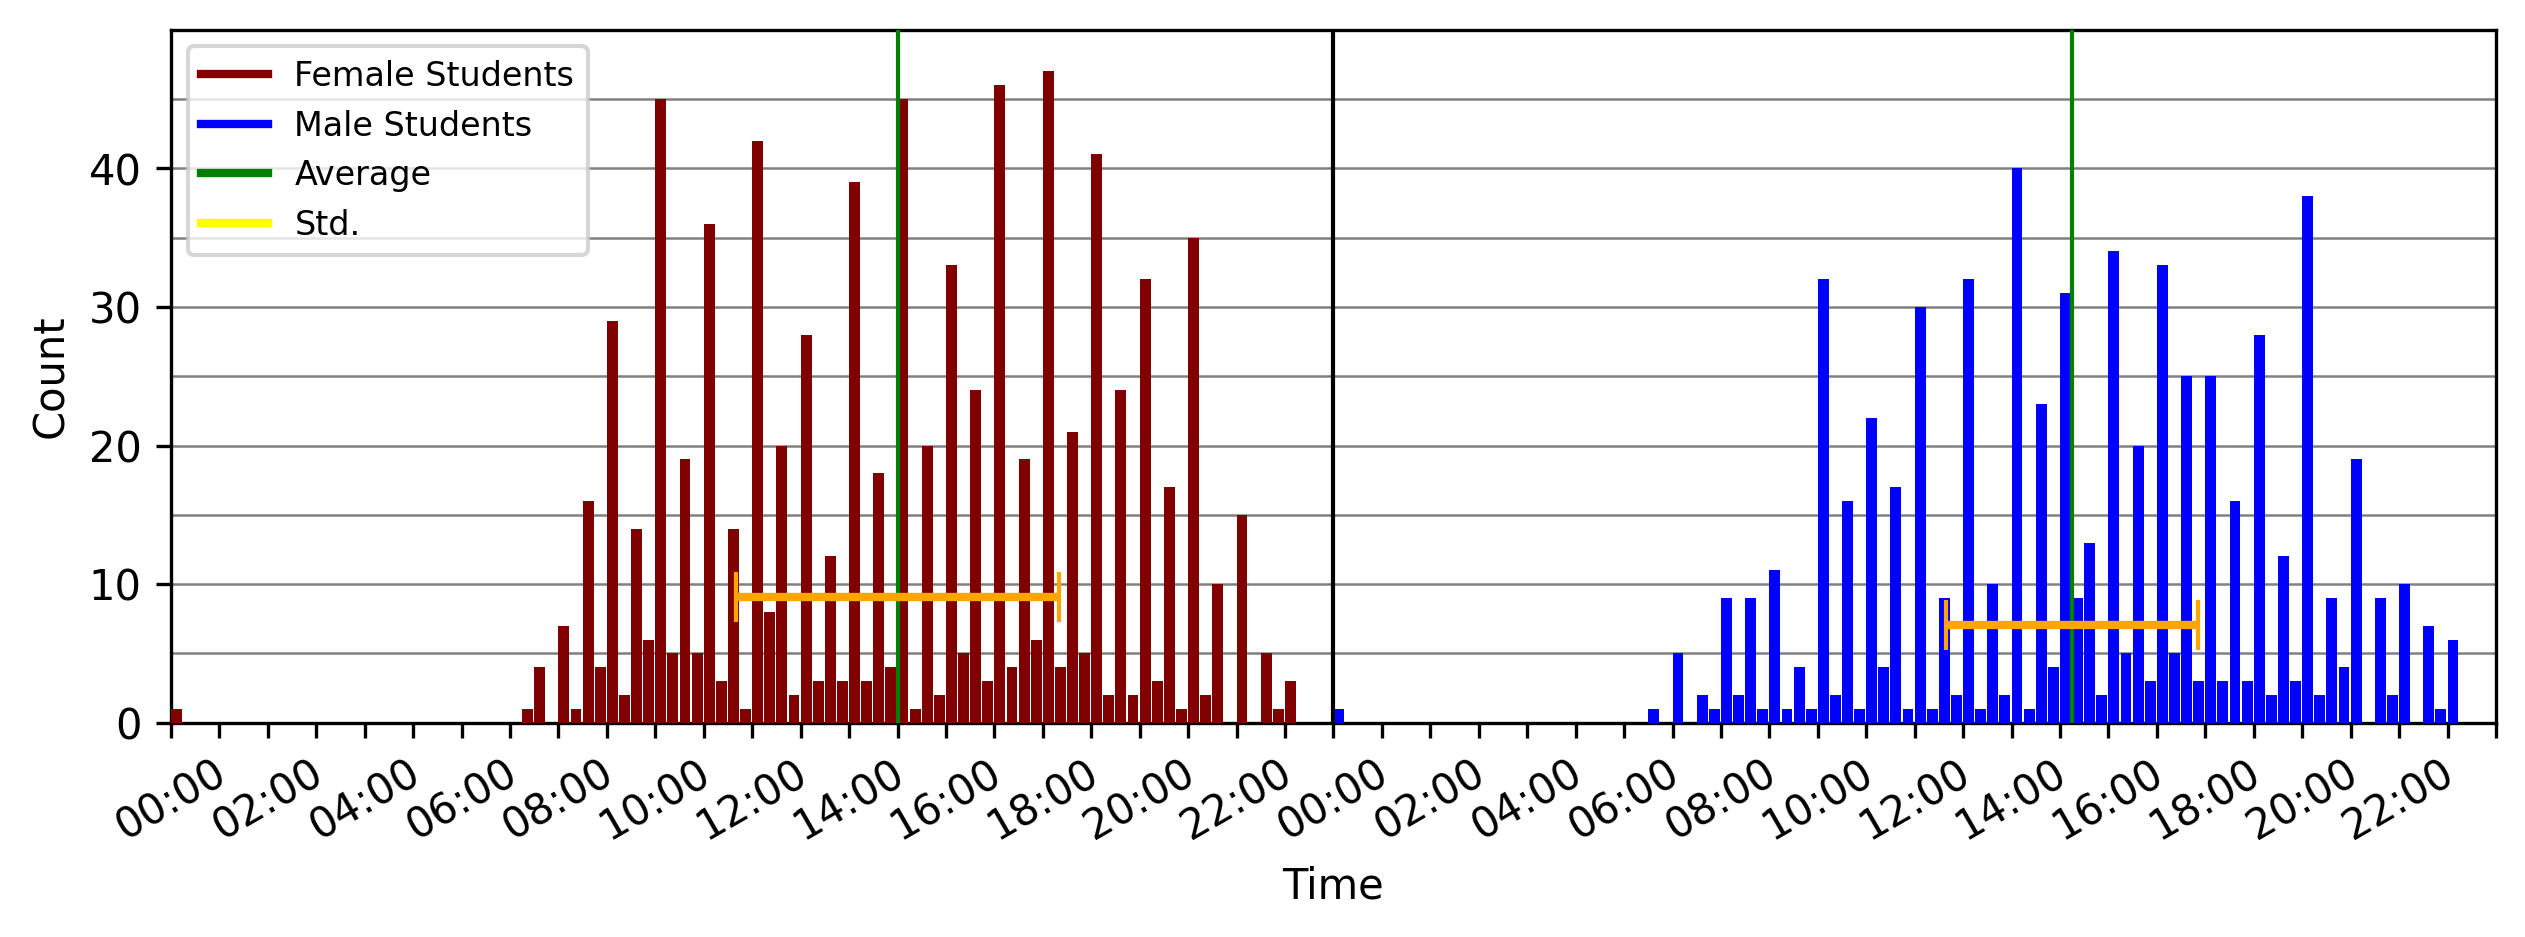

In [68]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 3), sharex=False, dpi=300, zorder=4)

y_pos = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

ax.set_xlim(0, 192)
ax.set_ylim(0, 50)
ax.set_xticks(time_stamps)
ax.set_xticklabels(labels=time_labels, rotation=30)
ax.set_yticks(np.arange(0, 50, step=10))
for yc in y_pos:
    ax.axhline(y=yc, color='grey', linewidth=0.6, zorder=2)
ax.axvline(x=96, color='black', linewidth=1, zorder=4)

ax.set_xlabel("Time") 
ax.set_ylabel("Count")

ax.bar(intervals, np.concatenate((zeroes_array, all_data_men), axis=0), label='Set1', width=0.9, color='blue', align='edge', zorder=3)
ax.bar(intervals, np.concatenate((all_data_women, zeroes_array), axis=0), label='Set1', width=0.9, color='maroon', align='edge', zorder=3)

max_times_woman_all = np.flatnonzero(all_data_women == np.max(all_data_women)).tolist()
for index_times, times in enumerate(max_times_woman_all):
    max_times_woman_all[index_times] = f"{3*times // 12:02d}:{(3*times % 12) * 5:02d}"
    
max_times_man_all = np.flatnonzero(all_data_men == np.max(all_data_men)).tolist()
for index_times, times in enumerate(max_times_man_all):
    max_times_man_all[index_times] = f"{3*times // 12:02d}:{(3*times % 12) * 5:02d}"

men_average = np.round(np.average(np.arange(96), weights=all_data_men))
women_average = np.round(np.average(np.arange(96), weights=all_data_women))

ax.axvline(x=women_average, color='green', linewidth=1, zorder=4)
ax.errorbar(x=women_average, y=np.average(all_data_women), xerr=np.std(all_data_women), linewidth=2, capsize=6, zorder=4, color='green', ecolor='orange')
ax.axvline(x=men_average+96, color='green', linewidth=1, zorder=4)
ax.errorbar(x=men_average+96, y=np.average(all_data_men), xerr=np.std(all_data_men), linewidth=2, capsize=6, zorder=4, color='green', ecolor='orange')

custom_lines = [Line2D([0], [0], color='maroon', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='yellow', lw=2)]
ax.legend(custom_lines, ['Female Students', 'Male Students', 'Average', 'Std.'], prop={'size': 8}, loc='upper left')